# EDA

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from ast import literal_eval

from collections import defaultdict

In [2]:
def get_hashtag_counts(json):
    
    # Create empty dict where values are stored
    hashtag_count = defaultdict(int)
    
    # Iterate over all tweets, retrieve their hashtags and increment the counter by one
    for tweet in json["data"]:
        try:
            hashtags = tweet["entities"]["hashtags"]
            for hashtag in hashtags:
                hashtag_count[hashtag["tag"]] +=1
        except KeyError:
            continue
            
    return hashtag_count

def get_annotation_counts(json):
    
    annotation_count = defaultdict(int)

    for tweet in json["data"]:
        try:
            annotations = tweet["entities"]["annotations"]
            for annotation in annotations:
                annotation_count[annotation["normalized_text"]] +=1
        except KeyError:
            continue
            
    return annotation_count

In [3]:
def get_entity_count(series):
    dict_count = defaultdict(int)
    
    for entities in series:
        for entity in entities:
            if len(entity) > 0:
                dict_count[entity] += 1
            
    return dict_count

In [4]:
def get_entity_count_by_interval(df,interval,entity_type):
    entity_df = pd.DataFrame()
    
    if interval == "week":
        col_name = "year_calendar_week"
    elif interval == "month":
        col_name = "year_month"
        
    entity_type = entity_type.lower()
        
    df_sorted = df.sort_values(["created_at"])
    periods = list(df_sorted[col_name].drop_duplicates())
    
    for period in periods:
        df_sliced = df[df[col_name] == period]
        entity_count = get_entity_count(df_sliced[entity_type])
        entity_count_sorted = sorted(entity_count.items(), key=lambda x: x[1], reverse=True)
        
        entity_df[period] = pd.DataFrame(entity_count_sorted[:15]).iloc[:,0]
        
    return entity_df

In [185]:
def group_df(df,interval):
    
    if interval == "week":
        col_name = "year_calendar_week"
    elif interval == "month":
        col_name = "year_month"
    
    
    df_grouped = df.groupby([col_name])[['refugee', 'migrant', 'immigrant', 'asylum_seeker', 'other']].sum()
    df_grouped["total"] = df_grouped.sum(axis=1)
    
    return df_grouped

In [191]:
def plot_event_timeline(df, interval):
    
    df_grouped = group_df(df,interval)
    
    plt.figure(figsize=(16, 8))
    plt.plot(df_grouped["total"])
    plt.title(f"Number of tweets about refugees and related groups by {interval}")
    plt.xticks(rotation=90)
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.plot(df_grouped["refugee"], label ="refugee")
    plt.plot(df_grouped["migrant"], label ="migrant")
    plt.plot(df_grouped["immigrant"], label ="immigrant")
    plt.plot(df_grouped["asylum_seeker"], label ="asylum seeker")
    plt.plot(df_grouped["other"], label ="other")
    plt.title(f"Grouped number of tweets about refugees and related groups by {interval}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [286]:
def plot_entity_timeline(df, interval, entity_list, entity_type):
    
    plt.figure(figsize=(16, 8))
    
    for entity in entity_list:
        
        df_entity = df[df[entity_type].apply(lambda x: element_in_list(x,[entity]))]
        df_grouped = group_df(df_entity,interval)
        plt.plot(df_grouped["total"], label = entity)
    
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [272]:
def element_in_list(entities,qualifiers):
    #if any(item in entities for item in qualifiers):
    #    return True
    #return False

    if bool(set(entities).isdisjoint(set(qualifiers))):
        return False
    return True
    

In [74]:
# Read the tweets csv
df_tweets = pd.read_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\df_tweets.csv",
                        converters={"hashtags": lambda x: x.strip("[]").replace("'","").split(", "),
                                    "mentions": lambda x: x.strip("[]").replace("'","").split(", "),
                                    "annotations": lambda x: x.strip("[]").replace("'","").split(", ")})

# Drop unnecessary index column
df_tweets.drop("Unnamed: 0", axis=1, inplace=True)

# Rename columns
#df_tweets = df_tweets.rename(columns={'public_metrics.retweet_count': 'retweet_count',
#                                      'public_metrics.reply_count': 'reply_count',
#                                      'public_metrics.like_count': 'like_count',
#                                      'public_metrics.quote_count': 'quote_count'})
df_tweets.head()

,source,text,lang,id,created_at,author_id,retweet_count,reply_count,like_count,quote_count,hashtags,mentions,annotations
0,Twitter for Android,There are too many reliable reports and first-...,en,1350390669043499013,2021-01-16T10:33:19.000Z,1327278886380515328,1,0,0,0,"[eritrea, bidentakeaction, stopwarontigray, ti...",[joebiden],[]
1,Twitter Web App,"Despite repeated requests, @Refugees and other...",en,1350390657576300544,2021-01-16T10:33:16.000Z,1323903491044188161,0,0,0,0,"[tigray, stopwarontigray, tigraygenocide, bide...","[refugees, un, joebiden]","[shimelba, hitsats]"
2,Twitter for Android,"“When the air bombing and the attacks began, I...",en,1350390643986599937,2021-01-16T10:33:13.000Z,1324130252008816640,0,0,1,0,[bidentakeaction],"[joebiden, kamalaharris, yohannesabraham]",[]
3,Twitter Web App,"""ongoing insecurity &amp; allegations of grave...",en,1350390618695020546,2021-01-16T10:33:07.000Z,1112761003,0,0,0,0,"[tigraygenocide, bidenactnow, protectrefugees]","[un, joebiden, eu_commission, refugees, josepb...",[eritrea]
4,Twitter for iPhone,"MOTHER \n\nMother, I do not cry who cries, \nm...",en,1350390607928295424,2021-01-16T10:33:04.000Z,1212824799107375105,0,1,0,0,[],[],[]


### Most frequent hashtags, mentions, and annotations

In [244]:
hashtag_count = get_entity_count(df_tweets["hashtags"])
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 75317),
 ('tigraygenocide', 72300),
 ('tigray', 61415),
 ('covid19', 52651),
 ('s386', 38500),
 ('stopwarontigray', 33835),
 ('migrants', 33357),
 ('immigrants', 32076),
 ('ethiopia', 26012),
 ('immigration', 25445),
 ('refugee', 23878),
 ('iraqi_refugees_look_for_homeland', 23353),
 ('dv2020', 20562),
 ('dv2021', 20269),
 ('worldrefugeeday', 17910),
 ('unblocks386', 17321),
 ('refugeeswelcome', 16179),
 ('passs386', 13673),
 ('eritrea', 13287),
 ('allowaccesstotigray', 13147),
 ('immigrant', 12955),
 ('passhr1044', 12900),
 ('sudan', 12234),
 ('migration', 12084),
 ('standwithiraqirefugees', 11995)]

In [76]:
mention_count = get_entity_count(df_tweets["mentions"])
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('realdonaldtrump', 145428),
 ('refugees', 129576),
 ('joebiden', 95065),
 ('pritipatel', 84930),
 ('un', 66752),
 ('potus', 62046),
 ('nigel_farage', 60651),
 ('change', 48592),
 ('borisjohnson', 40016),
 ('kamalaharris', 36178),
 ('hrw', 31772),
 ('senatordurbin', 30059),
 ('vp', 26087),
 ('unhumanrights', 25801),
 ('senrickscott', 24826),
 ('amnesty', 24228),
 ('youtube', 23672),
 ('filippograndi', 23551),
 ('eu_commission', 23530),
 ('repzoelofgren', 22316),
 ('cnn', 22062),
 ('skynews', 21293),
 ('aoc', 20592),
 ('ukhomeoffice', 18801),
 ('abiyahmedali', 18796)]

In [77]:
annotation_count = get_entity_count(df_tweets["annotations"])
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('trump', 418727),
 ('us', 224256),
 ('uk', 217712),
 ('america', 199747),
 ('biden', 156215),
 ('france', 95267),
 ('turkey', 91664),
 ('canada', 90024),
 ('europe', 89927),
 ('u.s.', 81832),
 ('india', 73542),
 ('americans', 70829),
 ('usa', 69697),
 ('obama', 63827),
 ('mexico', 56439),
 ('china', 55380),
 ('eu', 53286),
 ('germany', 52830),
 ('britain', 44080),
 ('greece', 41866),
 ('united states', 41590),
 ('democrats', 41420),
 ('australia', 39665),
 ('god', 38349),
 ('sudan', 36979)]

### Add additional date columns (Year, Month, Calendar Week, etc)

In [78]:
df_tweets["created_at"] = pd.to_datetime(df_tweets["created_at"])

In [79]:
str(df_tweets["created_at"].dt.year[0])

'2021'

In [80]:
df_tweets["year"] = df_tweets["created_at"].dt.year.astype(str)
df_tweets["calendar_week"] = df_tweets["created_at"].apply(lambda x: x.strftime("%W")) #Monday considered as first day of the week
df_tweets["year_month"] = df_tweets["year"] + "_" + df_tweets["created_at"].dt.month.astype(str)
df_tweets["year_calendar_week"] = df_tweets["year"] + "_" + df_tweets["calendar_week"]

In [81]:
df_tweets.head()

,source,text,lang,id,created_at,author_id,retweet_count,reply_count,like_count,quote_count,hashtags,mentions,annotations,year,calendar_week,year_month,year_calendar_week
0,Twitter for Android,There are too many reliable reports and first-...,en,1350390669043499013,2021-01-16 10:33:19+00:00,1327278886380515328,1,0,0,0,"[eritrea, bidentakeaction, stopwarontigray, ti...",[joebiden],[],2021,02,2021_1,2021_02
1,Twitter Web App,"Despite repeated requests, @Refugees and other...",en,1350390657576300544,2021-01-16 10:33:16+00:00,1323903491044188161,0,0,0,0,"[tigray, stopwarontigray, tigraygenocide, bide...","[refugees, un, joebiden]","[shimelba, hitsats]",2021,02,2021_1,2021_02
2,Twitter for Android,"“When the air bombing and the attacks began, I...",en,1350390643986599937,2021-01-16 10:33:13+00:00,1324130252008816640,0,0,1,0,[bidentakeaction],"[joebiden, kamalaharris, yohannesabraham]",[],2021,02,2021_1,2021_02
3,Twitter Web App,"""ongoing insecurity &amp; allegations of grave...",en,1350390618695020546,2021-01-16 10:33:07+00:00,1112761003,0,0,0,0,"[tigraygenocide, bidenactnow, protectrefugees]","[un, joebiden, eu_commission, refugees, josepb...",[eritrea],2021,02,2021_1,2021_02
4,Twitter for iPhone,"MOTHER \n\nMother, I do not cry who cries, \nm...",en,1350390607928295424,2021-01-16 10:33:04+00:00,1212824799107375105,0,1,0,0,[],[],[],2021,02,2021_1,2021_02


In [82]:
df_tweets["refugee"] = df_tweets["text"].apply(lambda x: ("refugee" or "refugees") in x.lower())
df_tweets["migrant"] = df_tweets["text"].apply(lambda x: ("migrant" or "migrants") in x.lower())
df_tweets["immigrant"] = df_tweets["text"].apply(lambda x: ("immigrant" or "immigrants") in x.lower())
df_tweets["asylum_seeker"] = df_tweets["text"].apply(lambda x: ("asylum" and ("seeker" or "seekers")) in x.lower())
df_tweets["other"] = df_tweets["text"].apply(lambda x: (("displaced" or "stateless") and ("people" or "person" or "persons")) in x.lower())

In [83]:
df_tweets.head()

,source,text,lang,id,created_at,author_id,retweet_count,reply_count,like_count,quote_count,...,annotations,year,calendar_week,year_month,year_calendar_week,refugee,migrant,immigrant,asylum_seeker,other
0,Twitter for Android,There are too many reliable reports and first-...,en,1350390669043499013,2021-01-16 10:33:19+00:00,1327278886380515328,1,0,0,0,...,[],2021,02,2021_1,2021_02,True,False,False,False,False
1,Twitter Web App,"Despite repeated requests, @Refugees and other...",en,1350390657576300544,2021-01-16 10:33:16+00:00,1323903491044188161,0,0,0,0,...,"[shimelba, hitsats]",2021,02,2021_1,2021_02,True,False,False,False,False
2,Twitter for Android,"“When the air bombing and the attacks began, I...",en,1350390643986599937,2021-01-16 10:33:13+00:00,1324130252008816640,0,0,1,0,...,[],2021,02,2021_1,2021_02,False,False,False,False,True
3,Twitter Web App,"""ongoing insecurity &amp; allegations of grave...",en,1350390618695020546,2021-01-16 10:33:07+00:00,1112761003,0,0,0,0,...,[eritrea],2021,02,2021_1,2021_02,True,False,False,False,False
4,Twitter for iPhone,"MOTHER \n\nMother, I do not cry who cries, \nm...",en,1350390607928295424,2021-01-16 10:33:04+00:00,1212824799107375105,0,1,0,0,...,[],2021,02,2021_1,2021_02,True,False,False,False,False


### Frequency of Tweets over Time (also seperated by refugee/migrant/etc.)

In [188]:
df_tweets_by_week = group_df(df_tweets,"week")
df_tweets_by_week.head()

,refugee,migrant,immigrant,asylum_seeker,other,total
year_calendar_week,,,,,,
2020_22,38086,179661,110803,6157,27971,362678
2020_23,36608,128397,77720,6366,20929,270020
2020_24,84044,128196,89324,14129,26372,342065
2020_25,54751,124429,84959,22243,24697,311079
2020_26,40770,110147,79277,8720,19946,258860


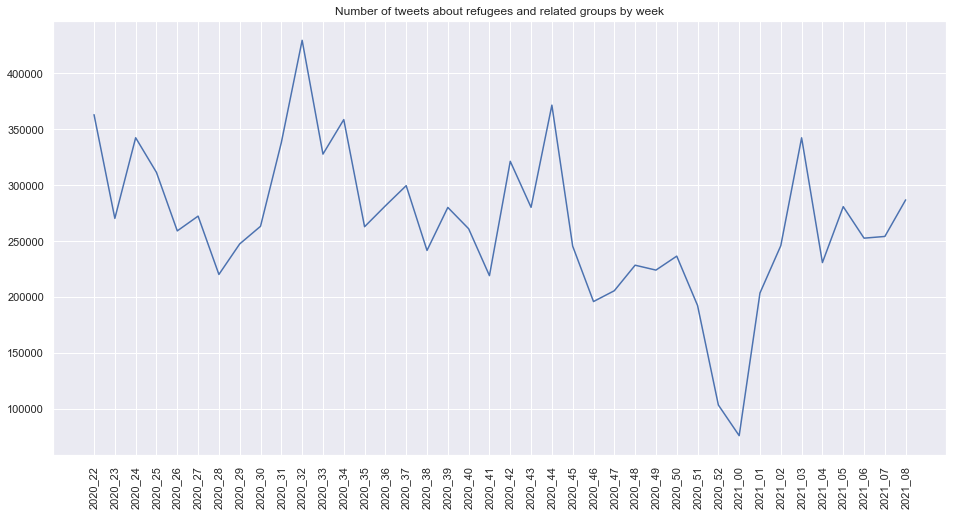

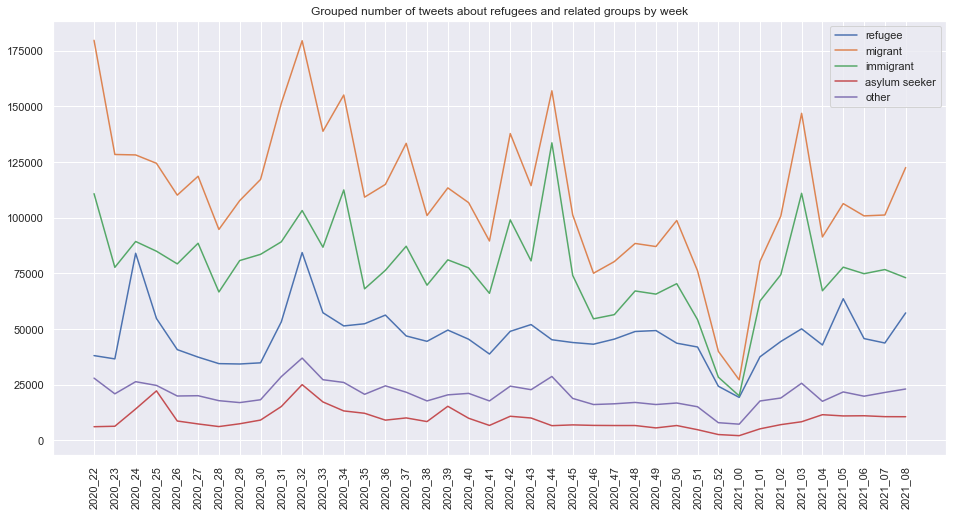

In [192]:
plot_event_timeline(df_tweets,"week")

In [224]:
df_hashtags_week["2020_44"]

0                             refugees
1                         election2020
2                      bidenharris2020
3                           immigrants
4                                 vote
5                                legal
6                              covid19
7                              armenia
8                             migrants
9                          unblocks386
10                              vienna
11                      ebarbanglaybjp
12    iraqi_refugees_look_for_homeland
13                                s386
14                         immigration
Name: 2020_44, dtype: object

### Most frequent hashtags per month

In [90]:
df_hashtags_month = get_entity_count_by_interval(df_tweets,"month","hashtags")
df_hashtags_month

,2020_6,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12,2021_1,2021_2
0,worldrefugeeday,s386,refugees,refugees,refugees,refugees,tigray,tigraygenocide,tigraygenocide
1,covid19,passs386,covid19,s386isfair,armenia,tigray,stopwarontigray,tigray,tigray
2,refugees,covid19,migrants,rickcantonesescott,covid19,covid19,passhr1044,stopwarontigray,allowaccesstotigray
3,migrants,durbinliesimmigrantsdie,unblocks386,covid19,artsakh,immigrants,refugees,bidenactnow,dv2020
4,refugeeweek2020,refugees,s386,s386,migrants,stopwarontigray,ethiopia,dv2021,dv2021
5,immigration,immigrants,refugeeswelcome,iraqi_refugees_look_for_homeland,immigrants,ethiopia,hr1044good4usa,dv2020,pp10014
6,blacklivesmatter,immigration,immigrantsdiewhendurbinlies,migrants,debates2020,iraqi_refugees_look_for_homeland,tigraygenocide,bidentakeaction,refugees
7,s386,unblocks386,immigrants,moria,iraqi_refugees_look_for_homeland,migrants,hr1044mustpass,ethiopia,unityforethiopia
8,immigrants,immigrantsdiewhendurbinlies,durbinfightsoutsourcerslie,stopicetransfers,immigration,tigraygenocide,keepyourpromise,refugees,tplf
9,refugee,migrants,webackdurbin,unblocks386,refugee,immigration,sudan,noban,ethiopia


In [91]:
df_mentions_month = get_entity_count_by_interval(df_tweets,"month","mentions")
df_mentions_month

,2020_6,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12,2021_1,2021_2
0,change,realdonaldtrump,pritipatel,realdonaldtrump,realdonaldtrump,realdonaldtrump,refugees,joebiden,potus
1,realdonaldtrump,senatordurbin,nigel_farage,senrickscott,joebiden,refugees,repzoelofgren,refugees,refugees
2,refugees,dnc,realdonaldtrump,pritipatel,refugees,joebiden,un,un,vp
3,nigel_farage,dncwarroom,borisjohnson,garylineker,pritipatel,pritipatel,senmikelee,kamalaharris,un
4,pritipatel,refugees,skynews,refugees,laurenwitzkede,kamalaharris,realdonaldtrump,potus,secblinken
5,sonusood,nigel_farage,refugees,nigel_farage,flotus,un,hrw,ablinken,amnesty
6,senatordurbin,pritipatel,joebiden,chrishartline,un,hrw,unocha,lindat_g,joebiden
7,narendramodi,change,bettemidler,borisjohnson,senrickscott,unhumanrights,joebiden,pritipatel,eu_commission
8,borisjohnson,joebiden,senatordurbin,joebiden,youtube,borisjohnson,filippograndi,vp,hrw
9,joebiden,iamjohnoliver,benandjerrysuk,change,borisjohnson,abiyahmedali,abiyahmedali,unhumanrights,alimayorkas


In [92]:
df_annotations_month = get_entity_count_by_interval(df_tweets,"month","annotations")
df_annotations_month

,2020_6,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12,2021_1,2021_2
0,trump,trump,uk,trump,trump,trump,trump,trump,biden
1,us,us,trump,uk,us,us,us,biden,trump
2,america,america,france,us,america,america,uk,us,us
3,uk,uk,us,america,uk,biden,america,america,america
4,india,canada,america,europe,biden,uk,sudan,uk,uk
5,turkey,turkey,europe,greece,france,europe,turkey,tigray,mexico
6,canada,u.s.,britain,turkey,u.s.,canada,canada,americans,u.s.
7,europe,usa,eu,france,obama,obama,germany,turkey,tigray
8,u.s.,india,turkey,canada,canada,turkey,ethiopia,u.s.,ethiopia
9,supreme court,americans,canada,eu,europe,sudan,biden,usa,texas


### Most frequent entities per week

In [93]:
df_hashtags_week = get_entity_count_by_interval(df_tweets,"week","hashtags")
df_hashtags_week

,2020_22,2020_23,2020_24,2020_25,2020_26,2020_27,2020_28,2020_29,2020_30,2020_31,...,2020_52,2021_00,2021_01,2021_02,2021_03,2021_04,2021_05,2021_06,2021_07,2021_08
0,covid19,covid19,worldrefugeeday,deportallrefugees,covid19,covid19,covid19,s386,immigrantsdiewhendurbinlies,covid19,...,stopwarontigray,tigraygenocide,tigraygenocide,tigraygenocide,tigraygenocide,tigraygenocide,tigraygenocide,tigraygenocide,tigraygenocide,shameonamnesty
1,blacklivesmatter,refugees,refugees,sendbackafghanrefugees,refugees,refugees,karabakhisazerbaijan,passs386,unblocks386,refugees,...,tigraygenocide,tigray,tigray,tigray,bidenactnow,dv2020,tigray,dv2020,tigray,tigraygenocide
2,migrants,migrants,refugeeweek2020,covid19,s386,immigration,refugees,durbinliesimmigrantsdie,s386,migrants,...,tigray,stopwarontigray,stopwarontigray,bidentakeaction,tigray,dv2021,allowaccesstotigray,allowaccesstotigray,dv2021,unityforethiopia
3,refugees,blacklivesmatter,covid19,refugees,yemencrisis,immigrants,humanrights,covid19,durbinfightsoutsourcerslie,s386,...,ethiopia,ethiopia,ethiopia,dv2021,unscactnow,bidenactnow,dv2020,dv2021,dv2020,tplf
4,migrantworkers,immigration,palestinianrefugees,immigration,immigration,s386,osce,refugees,webackdurbin,refugeeswelcome,...,refugees,dv2021,refugees,dv2020,bidentakeaction,refugees,ethiopia,pp10014,pp10014,tigray
5,coronavirus,s386,daca,s386,immigrants,india,stoparmenianoccupation,immigration,covid19,immigrants,...,stopabiy,djibouti,iraqi_refugees_look_for_homeland,bidenactnow,refugees,tigray,pp10014,tigray,allowaccesstotigray,amnestyusedtplfsources
6,immigration,coronavirus,withrefugees,immigrants,migrants,migrants,immigration,immigrants,refugees,webackdurbin,...,opentigray,blm,eritrea,noban,eritreaoutoftigray,iraqi_refugees_look_for_homeland,dv2021,refugees,refugees,refugees
7,migration,migration,yemencrisis,migrants,migration,migration,stoparmenianaggression,trump,passs386,durbinfightsoutsourcerslie,...,warontigray,ethiopian,sudan,stopwarontigray,dv2020,trudeauactnow,tigraiopen4humanitarianassistance,100daysofgenocide,savediversityvisa,tplfisthecause
8,immigrants,immigrants,refugeeweek,standwithiraqirefugees,deportallrefugeesfromsindh,mignation,immigrants,migration,immigrants,immigration,...,eritrea,refugees,blm,familyvisa,iraqi_refugees_look_for_homeland,stopwarontigray,uplifttigraiethiopia,tigraycantwait,getethiopianfactsright,getethiopianfactsright
9,s386,patientsnotpassports,worldrefugeeday2020,migration,refugee,refugee,migrants,freethemall,migrants,immigrationnation,...,blm,iraqi_refugees_look_for_homeland,famine,refugees,ethiopia,pp10014,unscactnow,immigrants,drabiygovistryinghard,tigrayfacts


In [94]:
df_mentions_week = get_entity_count_by_interval(df_tweets,"week","mentions")
df_mentions_week

,2020_22,2020_23,2020_24,2020_25,2020_26,2020_27,2020_28,2020_29,2020_30,2020_31,...,2020_52,2021_00,2021_01,2021_02,2021_03,2021_04,2021_05,2021_06,2021_07,2021_08
0,change,change,refugees,realdonaldtrump,realdonaldtrump,realdonaldtrump,realdonaldtrump,senatordurbin,senatordurbin,pritipatel,...,refugees,un,un,joebiden,joebiden,potus,potus,potus,potus,refugees
1,realdonaldtrump,realdonaldtrump,realdonaldtrump,nigel_farage,change,change,nigel_farage,dnc,iamjohnoliver,nigel_farage,...,un,refugees,refugees,un,kamalaharris,vp,vp,refugees,refugees,amnesty
2,sonusood,refugees,change,refugees,refugees,goyafoods,refugees,dncwarroom,dnc,borisjohnson,...,hrw,nowthisnews,unhumanrights,refugees,potus,joebiden,refugees,un,secblinken,potus
3,refugees,pritipatel,marcomendicino,pritipatel,pritipatel,refugees,pritipatel,realdonaldtrump,nigel_farage,realdonaldtrump,...,nigel_farage,abiyahmedali,hrw,ablinken,refugees,pritipatel,un,hrw,vp,eu_commission
4,ukchange,sonusood,un,borisjohnson,joebiden,joebiden,senatordurbin,pritipatel,realdonaldtrump,skynews,...,realdonaldtrump,joebiden,realdonaldtrump,kamalaharris,lindat_g,refugees,secblinken,secblinken,joebiden,statedept
5,nigel_farage,narendramodi,joebiden,change,marcomendicino,senatordurbin,youtube,refugees,dickdurbin,mouthwaite,...,joebiden,unhumanrights,usun,lindat_g,ablinken,secblinken,justintrudeau,vp,un,voaamharic
6,pritipatel,amitshah,senatordurbin,skynews,senatordurbin,ilhanmn,joebiden,joebiden,pritipatel,change,...,unhumanrights,7piliers,joebiden,alimayorkas,un,whitehouse,joebiden,eu_commission,alimayorkas,marcgarneau
7,narendramodi,senatordurbin,pritipatel,senatordurbin,conservatives,pritipatel,aoc,borisjohnson,borisjohnson,bbcnews,...,kamalaharris,unesco,abiyahmedali,travelgov,pmtunisia,ablinken,amnesty,joebiden,hrw,vp
8,pmoindia,borisjohnson,borisjohnson,joebiden,whitehouse,whitehouse,ilhanmn,nigel_farage,sonusood,senatordurbin,...,toryboypierce,hrw,antonioguterres,ailanational,gopleader,presssec,unhumanrights,alimayorkas,cnn,nigel_farage
9,cdnchange,rahulgandhi,narendramodi,nytimes,uklabour,un,thehill,txcivilrights,refugees,lbc,...,abiyahmedali,nigel_farage,wfpchief,filippograndi,vp,un,alimayorkas,amnesty,filippograndi,un


In [95]:
df_annotations_week = get_entity_count_by_interval(df_tweets,"week","annotations")
df_annotations_week

,2020_22,2020_23,2020_24,2020_25,2020_26,2020_27,2020_28,2020_29,2020_30,2020_31,...,2020_52,2021_00,2021_01,2021_02,2021_03,2021_04,2021_05,2021_06,2021_07,2021_08
0,trump,trump,trump,trump,trump,trump,trump,trump,trump,uk,...,uk,sudan,trump,trump,biden,biden,biden,biden,biden,biden
1,india,america,supreme court,us,america,america,us,us,us,france,...,trump,tigray,america,biden,trump,trump,trump,us,us,trump
2,america,us,turkey,uk,us,us,america,america,uk,trump,...,us,trump,us,us,us,us,us,trump,america,us
3,us,india,us,america,uk,united states,uk,canada,america,us,...,america,uk,uk,america,america,uk,america,america,trump,uk
4,uk,uk,america,u.s.,canada,turkey,turkey,uk,usa,lebanon,...,brexit day,us,biden,uk,americans,america,tigray,mexico,mexico,america
5,canada,turkey,uk,turkey,turkey,uk,canada,usa,france,america,...,stewart lee,ethiopia,turkey,tigray,u.s.,turkey,eritrea,uk,texas,ethiopia
6,europe,canada,world refugee day,glasgow,americans,u.s.,u.s.,u.s.,canada,eu,...,kent refugees,america,canada,ethiopia,joe biden,europe,ethiopia,u.s.,uk,tigray
7,turkey,europe,india,india,india,canada,europe,turkey,europe,britain,...,canada,turkey,sudan,guatemala,uk,u.s.,uk,usa,u.s.,u.s.
8,usa,u.s.,canada,sindh,europe,americans,india,india,india,europe,...,twitter,um rakuba,tigray,eritrea,usa,napier barracks,u.s.,americans,turkey,europe
9,delhi,bjp,daca,canada,china,usa,americans,europe,u.s.,brexit,...,tigray,eu,usa,usa,mexico,canada,sudan,turkey,americans,qatar


## Identification of Events

### s386

#### Find all relevant hashtags

In [132]:
s386_hashtags_1 = ["s386","passs386","unblocks386","s386isfair"]

In [266]:
df_tweets_s386_1 = df_tweets[df_tweets["hashtags"].apply(lambda x: element_in_list(x,s386_hashtags_1))]
df_tweets_s386_1.shape

(50324, 22)

In [143]:
hashtag_count = get_entity_count(df_tweets_s386_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in s386_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('durbinliesimmigrantsdie', 8369),
 ('immigrantsdiewhendurbinlies', 8260),
 ('rickcantonesescott', 6373),
 ('rickbeijingscott', 6153),
 ('s386isgoodforamerica', 1825),
 ('nos386', 1743),
 ('hr1044', 1690),
 ('yess386', 1468),
 ('s386eliminatesdiscrimination', 1155),
 ('immigrants', 1052),
 ('gcbacklog', 994),
 ('homeishere', 856),
 ('fairness', 826),
 ('neverforget', 744),
 ('dirtypolitics', 743),
 ('disappointed', 742),
 ('passhr1044', 731),
 ('s386isnotfair', 648),
 ('senatemustpasss386', 584),
 ('standwithscott', 521),
 ('rosettarick', 498),
 ('ilpol', 477),
 ('nos386noharassment', 454),
 ('s386blockedflprotected', 449),
 ('s386outsourcingbill', 444)]

In [133]:
s386_hashtags_2 = s386_hashtags_1 + ["durbinliesimmigrantsdie","immigrantsdiewhendurbinlies","rickcantonesescott",
                                     "rickbeijingscott","s386isgoodforamerica","nos386","hr1044","yess386",
                                     "s386eliminatesdiscrimination","gcbacklog","passhr1044","s386isnotfair",
                                     "senatemustpasss386","standwithscott","nos386noharassment","s386blockedflprotected",
                                     "s386outsourcingbill"]

In [148]:
df_tweets_s386_2 = df_tweets[df_tweets["hashtags"].apply(lambda x: element_in_list(x,s386_hashtags_2))]
df_tweets_s386_2.shape

(70389, 22)

In [144]:
hashtag_count = get_entity_count(df_tweets_s386_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in s386_hashtags_2:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('hr1044good4usa', 8608),
 ('immigrants', 1286),
 ('webackdurbin', 1155),
 ('durbinfightsoutsourcerslie', 978),
 ('imwithdurbin', 904),
 ('homeishere', 870),
 ('fairness', 836),
 ('standwithdurbin', 807),
 ('neverforget', 744),
 ('dirtypolitics', 743),
 ('disappointed', 742),
 ('stophr1044', 529),
 ('academichalt', 511),
 ('h4kids', 503),
 ('rosettarick', 498),
 ('housebanschinese', 483),
 ('ilpol', 480),
 ('stops386', 457),
 ('checks4techs', 411),
 ('equality', 409),
 ('daca', 398),
 ('uniplung', 397),
 ('h1b', 396),
 ('h4eaddelays', 326),
 ('racist', 314)]

In [145]:
s386_hashtags_3 = s386_hashtags_2 + ["hr1044good4usa", "webackdurbin", "durbinfightsoutsourcerslie", "imwithdurbin",
                                     "standwithdurbin", "stophr1044", "academichalt","rosettarick","housebanschinese",
                                     "stops386", "checks4techs"]

In [149]:
df_tweets_s386_3 = df_tweets[df_tweets["hashtags"].apply(lambda x: element_in_list(x,s386_hashtags_3))]
df_tweets_s386_3.shape

(74954, 22)

In [152]:
s386_hashtag_qualifier = s386_hashtags_3

In [153]:
s386_hashtag_qualifier

['s386',
 'passs386',
 'unblocks386',
 's386isfair',
 'durbinliesimmigrantsdie',
 'immigrantsdiewhendurbinlies',
 'rickcantonesescott',
 'rickbeijingscott',
 's386isgoodforamerica',
 'nos386',
 'hr1044',
 'yess386',
 's386eliminatesdiscrimination',
 'gcbacklog',
 'passhr1044',
 's386isnotfair',
 'senatemustpasss386',
 'standwithscott',
 'nos386noharassment',
 's386blockedflprotected',
 's386outsourcingbill',
 'hr1044good4usa',
 'webackdurbin',
 'durbinfightsoutsourcerslie',
 'imwithdurbin',
 'standwithdurbin',
 'stophr1044',
 'academichalt',
 'rosettarick',
 'housebanschinese',
 'stops386',
 'checks4techs']

#### Create event qualifier

In [151]:
annotation_count = get_entity_count(df_tweets_s386_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:40]

[('america', 5773),
 ('us', 5760),
 ('usa', 5513),
 ('india', 2253),
 ('congress', 961),
 ('china', 879),
 ('daca', 874),
 ('indians', 750),
 ('durbin', 728),
 ('senator durbin', 713),
 ('us congress', 685),
 ('civilrightsact', 665),
 ('richard russell', 664),
 ('americans', 456),
 ('u.s.', 449),
 ('nǐ hǎo', 421),
 ('texas', 404),
 ('africa', 385),
 ('trump', 325),
 ('ms. hegar', 324),
 ('sen. durbin', 292),
 ('sen. rick scott', 287),
 ('mike lee', 279),
 ('florida', 251),
 ('dol', 242),
 ('john lewis', 227),
 ('god', 208),
 ('united', 204),
 ('senator cornyn', 194),
 ('united states', 184),
 ('rick scott', 179),
 ('sen durbin', 163),
 ('democrats', 158),
 ('bill', 156),
 ('south america', 153),
 ('senate', 152),
 ('dick durbin', 148),
 ('american hospital association', 124),
 ('biden', 113),
 ('us-born', 111)]

In [154]:
mention_count = get_entity_count(df_tweets_s386_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:40]

[('senatordurbin', 24915),
 ('senrickscott', 21967),
 ('senmikelee', 15335),
 ('repzoelofgren', 13994),
 ('dnc', 13476),
 ('dncwarroom', 7811),
 ('chrishartline', 6746),
 ('iamjohnoliver', 5944),
 ('dickdurbin', 5556),
 ('senatedems', 4355),
 ('joebiden', 2774),
 ('realdonaldtrump', 2666),
 ('senategop', 2364),
 ('scottforflorida', 2174),
 ('kamalaharris', 1704),
 ('speakerpelosi', 1428),
 ('ailanational', 1127),
 ('housedemocrats', 1125),
 ('cnn', 1042),
 ('potus', 815),
 ('housegop', 770),
 ('gcbcoalition', 721),
 ('immivoice', 721),
 ('senschumer', 712),
 ('jaredkushner', 624),
 ('alimayorkas', 493),
 ('foxnews', 476),
 ('uscis', 465),
 ('whitehouse', 441),
 ('mitindc', 423),
 ('vp', 418),
 ('housejudiciary', 411),
 ('johncornyn', 399),
 ('tim_cook', 390),
 ('gop', 379),
 ('ckuck', 370),
 ('miamiherald', 355),
 ('nicolasmaduro', 353),
 ('aauniversities', 341),
 ('mjhegar', 338)]

In [155]:
s386_event_qualifier = ["s386","durbin","hr1044", "scott"]

#### Create event dataset

In [177]:
s386_qualifier = set(s386_event_qualifier + s386_hashtag_qualifier)

In [179]:
df_tweets_s386 = df_tweets[df_tweets["text"].apply(lambda x: element_in_list(x.lower().replace("#",""),s386_qualifier))]

In [180]:
df_tweets_s386.shape

(126115, 22)

#### Visualize event

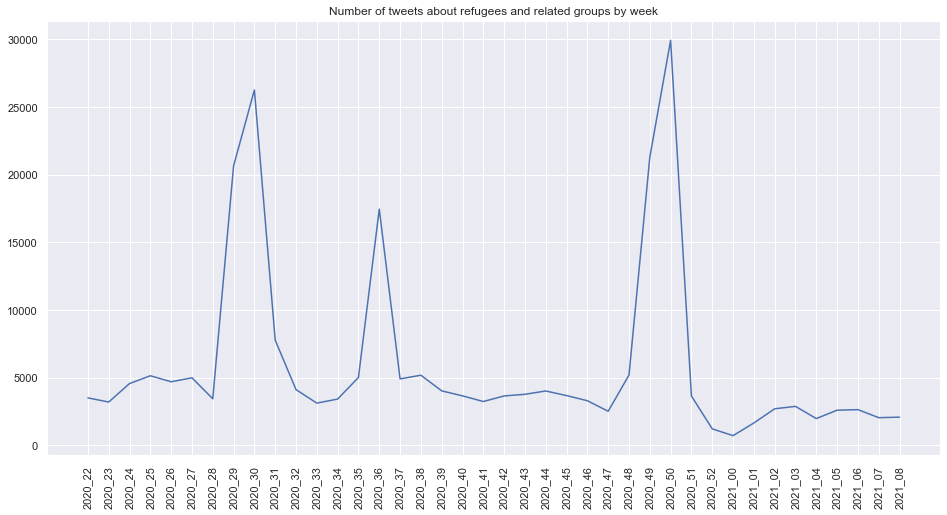

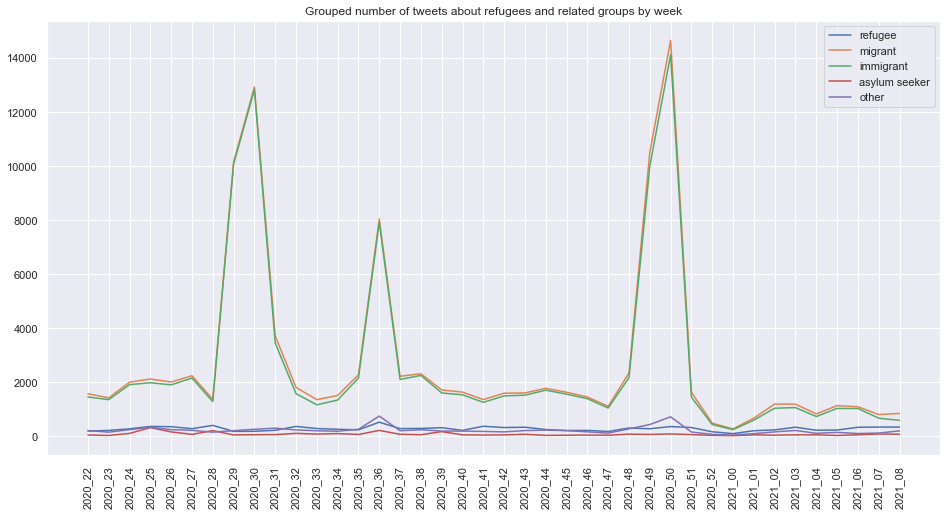

In [292]:
plot_event_timeline(df_tweets_s386,"week")

### Moria

#### Find all relevant hashtags

In [197]:
moria_hashtags_1 = ["moria", "greece"]

In [198]:
df_tweets_moria_1 = df_tweets[df_tweets["hashtags"].apply(lambda x: element_in_list(x,moria_hashtags_1))]
df_tweets_moria_1.shape

(12351, 22)

In [199]:
hashtag_count = get_entity_count(df_tweets_moria_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in moria_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 2582),
 ('migrants', 1117),
 ('lesbos', 1110),
 ('turkey', 1066),
 ('eu', 914),
 ('lesvos', 891),
 ('news', 717),
 ('refugeesgr', 598),
 ('refugee', 576),
 ('leavenoonebehind', 540),
 ('moriacamp', 510),
 ('refugeeswelcome', 504),
 ('covid19', 491),
 ('europe', 487),
 ('fire', 450),
 ('germany', 357),
 ('migration', 314),
 ('humanrights', 302),
 ('greek', 283),
 ('coronavirus', 264),
 ('mitsotakis', 261),
 ('asylum', 245),
 ('asylumseekers', 241),
 ('karatepe', 224),
 ('migrant', 196)]

In [200]:
moria_hashtags_2 = moria_hashtags_1 + ["lesbos","lesvos","refugeesgr","moriacamp","fire","greek","mitsotakis","karatepe"]

In [201]:
df_tweets_moria_2 = df_tweets[df_tweets["hashtags"].apply(lambda x: element_in_list(x,moria_hashtags_2))]
df_tweets_moria_2.shape

(16019, 22)

In [202]:
hashtag_count = get_entity_count(df_tweets_moria_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in moria_hashtags_2:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 3299),
 ('migrants', 1399),
 ('turkey', 1155),
 ('eu', 1044),
 ('refugee', 794),
 ('news', 730),
 ('leavenoonebehind', 634),
 ('refugeeswelcome', 588),
 ('covid19', 573),
 ('europe', 561),
 ('germany', 402),
 ('migration', 389),
 ('humanrights', 380),
 ('asylum', 324),
 ('coronavirus', 313),
 ('asylumseekers', 295),
 ('migrant', 269),
 ('athens', 242),
 ('immigrants', 220),
 ('samos', 203),
 ('syria', 202),
 ('moria2', 191),
 ('pushbacks', 183),
 ('turkish', 152),
 ('freethekids', 142)]

In [205]:
moria_hashtags_3 = moria_hashtags_2 + ["moria2"]

In [206]:
df_tweets_moria_3 = df_tweets[df_tweets["hashtags"].apply(lambda x: element_in_list(x,moria_hashtags_3))]
df_tweets_moria_3.shape

(16122, 22)

In [211]:
moria_hashtag_qualifier = moria_hashtags_3

#### Create event qualifier

In [207]:
annotation_count = get_entity_count(df_tweets_moria_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:40]

[('greece', 2403),
 ('europe', 905),
 ('moria', 764),
 ('lesbos', 751),
 ('eu', 521),
 ('turkey', 489),
 ('lesvos', 374),
 ('germany', 321),
 ('prime minister', 253),
 ('athens', 195),
 ('kara tepe', 138),
 ('syria', 118),
 ('uk', 97),
 ('aegean', 66),
 ('amazon', 63),
 ('berlin', 62),
 ('erdogan', 61),
 ('afghanistan', 59),
 ('france', 59),
 ('turkish', 58),
 ('chios', 55),
 ('samos', 52),
 ('aegean sea', 52),
 ('unhcr', 43),
 ('moria camp', 39),
 ('italy', 38),
 ('mytilene', 36),
 ('us', 35),
 ('cyprus', 35),
 ('ireland', 34),
 ('moria refugee camp', 33),
 ('turkish coast guard', 32),
 ('greek', 32),
 ('netherlands', 31),
 ('covid', 30),
 ('merkel', 30),
 ('brussels', 29),
 ('frontex', 27),
 ('mediterranean', 26),
 ('ngo', 25)]

In [208]:
mention_count = get_entity_count(df_tweets_moria_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:40]

[('primeministergr', 574),
 ('refugees', 384),
 ('euhomeaffairs', 288),
 ('eu_commission', 272),
 ('bmi_bund', 251),
 ('ukhomeoffice', 241),
 ('nmitarakis', 240),
 ('ministeriejenv', 238),
 ('interieur_gouv', 228),
 ('hrw', 203),
 ('vonderleyen', 158),
 ('ylvajohansson', 132),
 ('unhcrgreece', 115),
 ('nytimes', 105),
 ('kmitsotakis', 103),
 ('un', 86),
 ('frontex', 73),
 ('msf', 66),
 ('europarl_en', 61),
 ('amnesty', 60),
 ('unmigration', 50),
 ('dwnews', 49),
 ('f_grillmeier', 49),
 ('msf_sea', 48),
 ('guardian', 48),
 ('eucopresident', 48),
 ('margschinas', 47),
 ('emmanuelmacron', 47),
 ('amnestyireland', 47),
 ('bbcworld', 44),
 ('hcoastguard', 43),
 ('rspaegean', 42),
 ('unhumanrights', 40),
 ('youtube', 40),
 ('katymfallon', 39),
 ('chooselove', 38),
 ('bbcnews', 38),
 ('eva_cosse', 37),
 ('eucouncil', 36),
 ('ajenglish', 36)]

In [209]:
moria_event_qualifier = []

#### Create event dataset

In [212]:
moria_qualifier = set(moria_event_qualifier + moria_hashtag_qualifier)

In [213]:
df_tweets_moria = df_tweets[df_tweets["text"].apply(lambda x: element_in_list(x.lower().replace("#",""),moria_qualifier))]

In [214]:
df_tweets_moria.shape

(147764, 22)

#### Visualize event

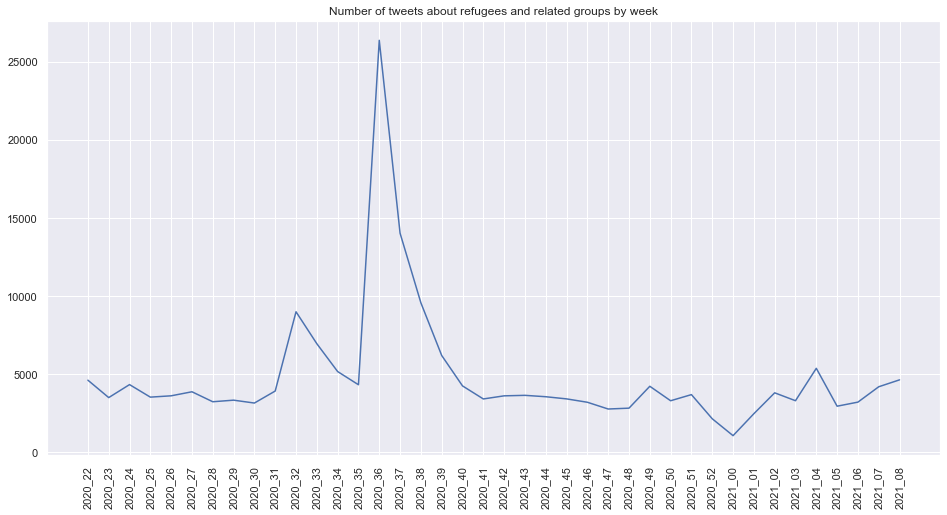

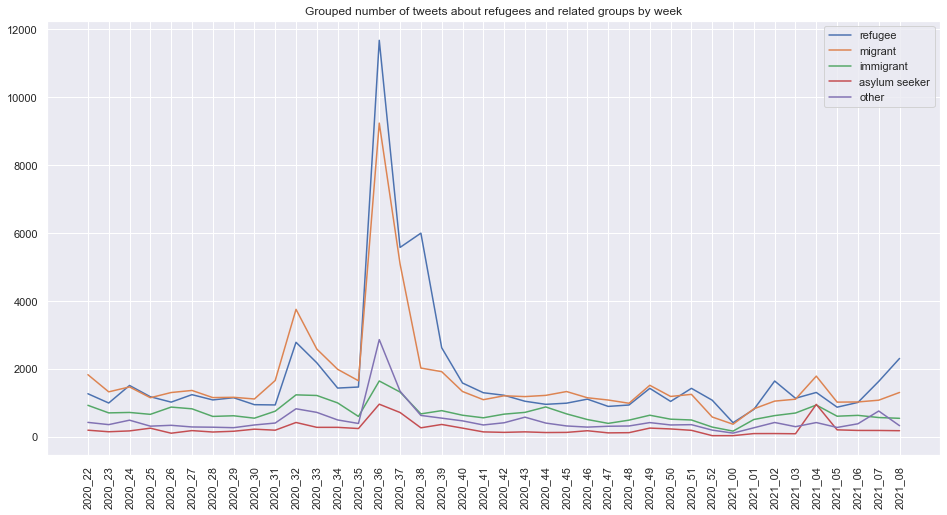

In [216]:
plot_event_timeline(df_tweets_moria,"week")

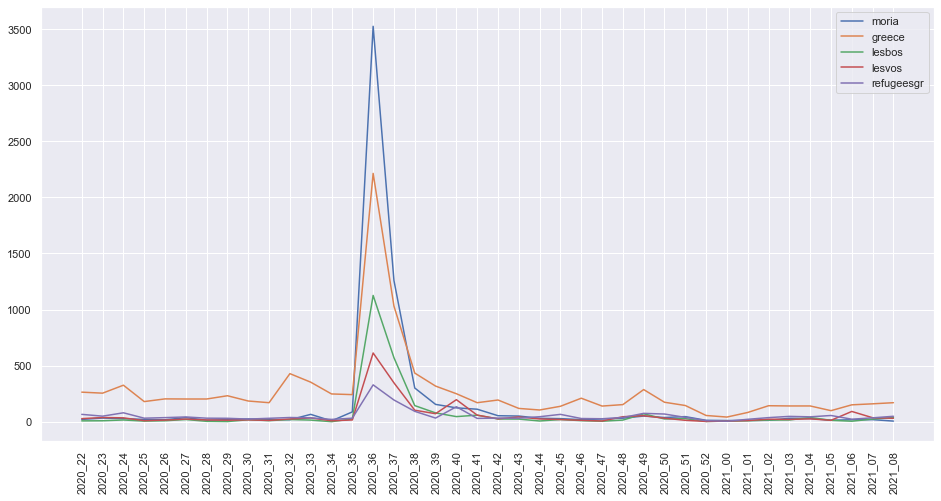

In [293]:
plot_entity_timeline(df_tweets_moria, "week", moria_hashtags_3[:5], "hashtags")